This notebook visualises the labels obtained during human evaluation. 


Each labeled portmanteau group consists of 3 portmanteaus generated by the simple algorithm, three portmanteau generated by Charmanteau and the "correct" portmanteau as obtained by the wikipedia dataset.

For each group the labels "first place", "second place", "third place" and "Very bad portmanteau" were provided.

The first part of this notebook visualises the results of the human evaluation. The second part constructs new ranking algorithms using adjusted weights based on the human annotations.

In [1]:
import json
import re
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
import numpy as np
from xgboost import DMatrix,train
import xgboost as xgb
import math

# Part 1: Visualisation of the results of the human evaluation

## Import the labels obtained during the human evaluation and its corresponding metadata

In [2]:
with open('../data/annotated_data.jsonl') as json_file:
    json_list = list(json_file)
annotated_list = []
for elem in json_list:
    result = json.loads(elem)
    if result['labels'] == []:
        continue
    else:
        annotated_list.append(result)
        
annotated_words = set()
groups = []
for elem in annotated_list:
    annotated_words = annotated_words.union(set(elem['meta']))
    groups.append(len(elem['meta']))

#get the corresponding meta data from the labeled fraction of the data
with open('../data/annotated_metadata.json') as json_file:
    meta_data = json.loads(json_file.read())
    
needed_meta_data = {}
for elem in annotated_words:
    needed_meta_data[str(elem)] = meta_data[str(elem)]
    
for elem in needed_meta_data:
    needed_meta_data[str(elem)]['label'] = "None"

In [3]:
def find_duplicate_label(duplicate_list,needed_meta_data, position):
    label1 = needed_meta_data[str(position+duplicate_list[0])]['label']
    label2 = needed_meta_data[str(position+duplicate_list[1])]['label']
    if label1 == label2:
        return
    if label1 == "None":
        needed_meta_data[str(position+duplicate_list[0])]['label'] = label2
        return
    if label2 == "None":
        needed_meta_data[str(position+duplicate_list[1])]['label'] = label1
        return
    if label1 == "First place":
        needed_meta_data[str(position+duplicate_list[1])]['label'] = label1
        return
    elif label2 == "First place":
        needed_meta_data[str(position+duplicate_list[0])]['label'] = label2
        return
    if label1 == "Second place":
        needed_meta_data[str(position+duplicate_list[1])]['label'] = label1
        return
    elif label2 == "Second place":
        needed_meta_data[str(position+duplicate_list[0])]['label'] = label2
        return

In [4]:
def find_corresponding_labels(annotated_list, needed_meta_data):
    for elem in annotated_list:
        words_start = [m.start() for m in re.finditer(',', elem['text'])]
        for label in elem['labels']:
            estimate = (label[0] + label[1])/2
            i = 0
            for starter in words_start:
                if estimate < starter:
                    needed_meta_data[str(elem['meta'][i])]['label'] = label[2]
                    break
                else:
                    i = i + 1
            if i == 6:
                needed_meta_data[str(elem['meta'][i])]['label'] = label[2]

In [5]:
find_corresponding_labels(annotated_list, needed_meta_data)

## Visualise the annotated portmanteaus

### Interpret the annotation labels for visualisation

In [6]:
k = 0
for index, i in enumerate(annotated_words):
    if index % 7 == 0:
        l = 0
    else: 
        continue
    words = []
    label = []
    for j in range(0,7):
        words.append(needed_meta_data[str(i+j)]['result'])
    for j in range(0,7):
        if words.count(needed_meta_data[str(i+j)]['result']) == 2:
            if needed_meta_data[str(i+j)]['predicted_by'] != 3:
                needed_meta_data[str(i+j)]['predicted_by'] = 4
            duplicat_list = [index for index, element in enumerate(words) if element == needed_meta_data[str(i+j)]['result']]
            if j > duplicat_list[0]:
                find_duplicate_label(duplicat_list,needed_meta_data, i)
    k += 1

In [7]:
overal = [0,0,0,0,0]
bad = [0,0,0,0,0]
first = [0,0,0,0,0]
second = [0,0,0,0,0]
third = [0,0,0,0,0]
bad_true = [0,0,0,0,0]
first_true = [0,0,0,0,0]
second_true = [0,0,0,0,0]
third_true = [0,0,0,0,0]
for index, elem in enumerate(needed_meta_data):
    overal[needed_meta_data[str(elem)]['predicted_by']] = overal[needed_meta_data[str(elem)]['predicted_by']] + 1
    if index % 7 == 6:
        if needed_meta_data[str(elem)]['label'] == 'Very bad portmanteau':
            bad_true[needed_meta_data[str(elem)]['predicted_by']] = bad_true[needed_meta_data[str(elem)]['predicted_by']] + 1
        if needed_meta_data[str(elem)]['label'] == 'First place':
            first_true[needed_meta_data[str(elem)]['predicted_by']] = first_true[needed_meta_data[str(elem)]['predicted_by']]+ 1
        if needed_meta_data[str(elem)]['label'] == 'Second place':
            second_true[needed_meta_data[str(elem)]['predicted_by']] = second_true[needed_meta_data[str(elem)]['predicted_by']]+ 1
        if needed_meta_data[str(elem)]['label'] == 'Third place':
            third_true[needed_meta_data[str(elem)]['predicted_by']] = third_true[needed_meta_data[str(elem)]['predicted_by']]+ 1
        
    else: 
        if needed_meta_data[str(elem)]['label'] == 'Very bad portmanteau':
            bad[needed_meta_data[str(elem)]['predicted_by']] = bad[needed_meta_data[str(elem)]['predicted_by']] + 1
        if needed_meta_data[str(elem)]['label'] == 'First place':
            first[needed_meta_data[str(elem)]['predicted_by']] = first[needed_meta_data[str(elem)]['predicted_by']]+ 1
        if needed_meta_data[str(elem)]['label'] == 'Second place':
            second[needed_meta_data[str(elem)]['predicted_by']] = second[needed_meta_data[str(elem)]['predicted_by']]+ 1
        if needed_meta_data[str(elem)]['label'] == 'Third place':
            third[needed_meta_data[str(elem)]['predicted_by']] = third[needed_meta_data[str(elem)]['predicted_by']]+ 1
            
first[0] = first_true[0]
second[0] = second_true[0]
third[0] = third_true[0]
bad[0] = bad_true[0]

first[3] = first_true[3]
second[3] = second_true[3]
third[3] = third_true[3]
bad[3] = bad_true[3]

first.append(first_true[2])
second.append(second_true[2])
third.append(third_true[2])
bad.append(bad_true[2])

first.append(first_true[3])
second.append(second_true[3])
third.append(third_true[3])
bad.append(bad_true[3])

first[4] = int(first[4]/2)
second[4] = int(second[4]/2)
third[4] = int(third[4]/2)
bad[4] = int(bad[4]/2)
first = [x/float(sum(first)) for x in first]
second = [x/float(sum(second)) for x in second]
third = [x/float(sum(third)) for x in third]
bad = [x/float(sum(bad)) for x in bad]

In [8]:
true_not_predicted = [first[0], second[0], third[0], bad[0]]
char_predicted = [first[1], second[1], third[1], bad[1]]
naive_predicted = [first[2], second[2], third[2], bad[2]]
true_both_predicted = [first[3], second[3], third[3], bad[3]]
both_predicted = [first[4], second[4], third[4], bad[4]]
charmanteau_true = [first[5], second[5], third[5], bad[5]]
naiv_true = [first[6], second[6], third[6], bad[6]]

<Figure size 432x288 with 0 Axes>

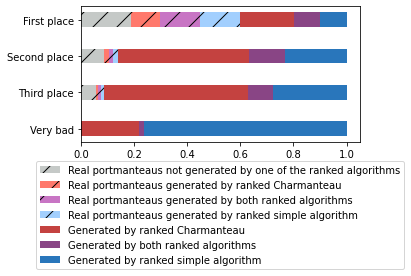

In [9]:
plt.figure(facecolor=(1, 1, 1))
plt.subplots(figsize=(5,2.5))
label1= plt.barh(y = ['First place','Second place','Third place','Very bad'], width= [(x + y + z + i+j + k+l) for x, y, z, i, j, k, l in zip(both_predicted,true_both_predicted,naive_predicted,char_predicted,true_not_predicted,charmanteau_true, naiv_true)],  color = 'xkcd:bluish',height=0.4 )

label2= plt.barh(y = ['First place','Second place','Third place','Very bad'], width= [(x + y + z + i+j +k) for x, y, z,i,j,k in zip(both_predicted,true_both_predicted,naiv_true,char_predicted,true_not_predicted,charmanteau_true)], color = 'xkcd:light eggplant',height=0.4)

label3= plt.barh(y = ['First place','Second place','Third place','Very bad'], width= [(x + y + z + i+j) for x, y, z,i,j in zip(char_predicted,true_both_predicted,true_not_predicted,charmanteau_true,naiv_true)], color = 'xkcd:reddish',height=0.4)

label4=plt.barh(y = ['First place','Second place','Third place','Very bad'], width= [(x + y + z + i) for x, y, z,i in zip(true_both_predicted,charmanteau_true,true_not_predicted, naiv_true)], color = 'xkcd:baby blue', hatch='/',height=0.4)

label5=plt.barh(y = ['First place','Second place','Third place','Very bad'], width= [(x + y + z) for x, y, z in zip(charmanteau_true,true_both_predicted,true_not_predicted)], color = 'xkcd:orchid', hatch='/',height=0.4)

label6=plt.barh(y = ['First place','Second place','Third place','Very bad'], width= [(x + y) for x, y in zip(charmanteau_true,true_not_predicted)], color = 'xkcd:salmon', hatch='/',height=0.4)

label7=plt.barh(y = ['First place','Second place','Third place','Very bad'], width= true_not_predicted, color = 'xkcd:silver', hatch='/',height=0.4)

#plt.legend(['Generated by ranked simple algorithm','Generated by both ranked algorithms','Generated by ranked Charmanteau','Real portmanteaus generated by ranked simple algorithm','Real portmanteaus generated by both ranked algorithms','Real portmanteaus generated by ranked Charmanteau','Real portmanteaus not generated by one of the ranked algorithms'],loc='upper center', bbox_to_anchor=(0.5,-0.1))


labels = ['Generated by ranked simple algorithm','Generated by both ranked algorithms','Generated by ranked Charmanteau','Real portmanteaus generated by ranked simple algorithm','Real portmanteaus generated by both ranked algorithms','Real portmanteaus generated by ranked Charmanteau','Real portmanteaus not generated by one of the ranked algorithms']
#plt.ytickslabels([1,2,3,4])
#plt.autoscale(enable=True, axis='y', tight=True)
plt.gca().invert_yaxis()
ax = plt.gca()
ax.legend(reversed([label1,label2,label3,label4,label5,label6,label7]), reversed(labels),loc='upper center', bbox_to_anchor=(0.5,-0.1))



# Part 2: Alternative versions of the portmanteau ranker algorithm using (part of) the annotated data

One ranker is constructed using all human evaluated data as weights


One ranker is constructed using only the best portmanteau as given by the human evaluated data


One ranker is constructed using the "correct" portmanteau as given by the portmanteau data set scraped from Wikipedia

In [10]:
def no_human_label(intermediate):
    labels = []
    for index, row in intermediate.iterrows():
        if row['portmanteau'] == True:
            labels.append(1)
        else:
            labels.append(0)
    return labels

In [11]:
#weights for the ranker:
# first : 3
# second : 2
# third : 1
# None : 0
# Very bad : -2
def transform_label(intermediate, order):
    labels = []
    for index, row in intermediate.iterrows():
        if order == False:
            if row['label'] == "First place":
                labels.append(1)
            else:
                labels.append(0)
        else:
            if row['label'] == "First place":
                labels.append(3)
            elif row['label'] == "Second place":
                labels.append(2)
            elif row['label'] == "Third place":
                labels.append(1)
            elif row['label'] == "None":
                labels.append(0)
            elif row['label'] == "Very bad portmanteau":
                labels.append(-2)
            else:
                labels.append(0)
    return labels

In [12]:
def data(needed_meta_data):
    metadata = pd.DataFrame.from_dict(needed_meta_data)
    metadata = metadata.transpose()
    label1 = transform_label(metadata, False)
    label2 = transform_label(metadata, True)
    label3 = no_human_label(metadata)
    data = metadata.drop(['prediction_place','result','root1','root2','predicted_by','portmanteau','label','ranking'],axis=1)
    annotated_data = metadata['label']
    data.columns
    return data,label1,label2,label3,annotated_data

def split(data_to_use, label1, label2,label3,annotated_data):
    gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
    gss.get_n_splits()

    for train_idx, test_idx in gss.split(data_to_use, label1, data_to_use['group']):
        indices = np.array([np.nan] * len(data_to_use))
        indices[train_idx] = 1
        indices[test_idx] = 0
        print("TRAIN:", train_idx, "TEST:", test_idx)
        indices = indices.astype(int)
    
    data = data_to_use.drop(['group'], axis = 1)
    columns = data.columns
    data = data.values.tolist()
    annotated_data = annotated_data.values.tolist()
    
    data_train = []
    label1_train = []
    label2_train= []
    label3_train= []
    data_test= []
    label1_test= []
    label2_test= []
    label3_test = []
    annotated_test = []
    
    for index in range(len(indices)):
        if indices[index] == 1: 
            data_train.append(data[index])
            label1_train.append(label1[index])
            label2_train.append(label2[index])
            label3_train.append(label3[index])
        if indices[index] == 0:
            data_test.append(data[index])
            label1_test.append(label1[index])
            label2_test.append(label2[index])
            label3_test.append(label3[index])
            annotated_test.append(annotated_data[index])
            
    data_test = pd.DataFrame(data_test, columns=columns)
    data_train = pd.DataFrame(data_train, columns=columns)
    data_test
    return data_train, label1_train, label2_train, label3_train, data_test, label1_test, label2_test, label3_test,annotated_test

In [13]:
data, label1, label2,label3,annotated_data = data(needed_meta_data)
data_train, label1_train, label2_train,label3_train, data_test, label1_test, label2_test, label3_test,annotated_test = split(data, label1, label2,label3,annotated_data)
group_train = [7] * int(len(data_train)/7.0)
group_test = [7] * int(len(data_test)/7.0)

TRAIN: [   0    1    2 ... 4897 4898 4899] TEST: [  14   15   16 ... 4876 4877 4878]


In [14]:
xgb_params ={    
    'booster' : 'gbtree',
    'eta': 0.1,
    'gamma' : 1.0 ,
    'min_child_weight' : 0.1,
    'objective' : 'rank:pairwise',
    'eval_metric' : 'merror',
    #'num_class': 3,  # 
    'max_depth' : 6,
    'num_round' : 4,
    'save_period' : 0 
}

In [15]:
def train_model(data_train, label_train, group_train, data_test, group_test):
    xgbTrain = DMatrix(data_train, label = label_train)
    xgbTrain.set_group(group_train)

    xgbTest = DMatrix(data_test)
    xgbTest.set_group(group_test)
    rankModel = xgb.train(params=xgb_params,dtrain=xgbTrain  )
    predicted_by_model = rankModel.predict(xgbTest)
    return predicted_by_model

### The three trained models:

In [16]:
ordered = train_model(data_train, label1_train, group_train, data_test, group_test)
non_ordered = train_model(data_train, label2_train, group_train, data_test, group_test)
no_human = train_model(data_train, label3_train, group_train, data_test, group_test)

[21:37:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { num_round, save_period } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:37:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { num_round, save_period } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:37:54] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { num_round, save_period } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or

### Evaluating the three models based on two performance techniques

Technique one: The ranked place of the best portmanteau (as indicated by the annotated data) in respect to the other 6 portmanteaus per group.


Technique two: using the DCG score to take into account the full obtained ranking

In [17]:
def plot_donut(data, save_name):
    fig, ax = plt.subplots(figsize=(10, 5), subplot_kw=dict(aspect="equal"))
    
    recipe = ["1st place",
              "2nd place",
              "3rd place",
              "4th place",
              "5th place or worse"
             ]
        
    data[4] = sum(data[4:])
    data = data[:5]
    wedges, texts,_ = ax.pie(data, wedgeprops=dict(width=0.6), startangle=-40, autopct='%1.2f%%',textprops={'fontsize': 12, 'weight':'bold'}, pctdistance=0.75)
    plt.setp(texts, fontweight=600)
    bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
    kw = dict(arrowprops=dict(arrowstyle="-"),
              bbox=bbox_props, zorder=0, va="center")

    for i, p in enumerate(wedges):
        ang = (p.theta2 - p.theta1)/2. + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = "angle,angleA=0,angleB={}".format(ang)
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                    horizontalalignment=horizontalalignment, **kw, size=12)

    plt.show()
    

In [18]:
def prediction(group_prediction, index):
    portmanteau = group_prediction[index]
    sorted_prediction = sorted(group_prediction)
    y = np.where(group_prediction == sorted_prediction[-1])
    x = sorted_prediction[::-1].index(portmanteau)
    worst_case = len(sorted_prediction) - 1 - sorted_prediction.index(portmanteau)
    count = sorted_prediction.count(portmanteau)
    return x,worst_case

In [19]:
def performance_measure(y_labels, y_prediction_labels, group, ordening):
    if ordening == True:
        waarde = 3
    else:
        waarde = 1
    predictions = [0,0,0,0,0,0,0]
    worst_case_prediction = [0,0,0,0,0,0,0]
    charmanteau = 0
    non_charmanteau = 0
    portmanteau = 0
    p = 0
    for i in range(len(group)):
        if ordening == True:
            if 3 not in y_labels[p:(p+group[i])]:
                p = p + group[i]
                continue
        else: 
            if y_labels[p:(p+group[i])] == [0,0,0,0,0,0,0]:
                p = p + group[i]
                continue
        predicted,worst_case = prediction(y_prediction_labels[p:(p+group[i])], y_labels[p:(p+group[i])].index(waarde))
        #predicted = prediction(y_prediction_labels[p:(p+group[i])], 0, ports_to_check_test[p:(p+group[i])])
        predictions[predicted] += 1
        worst_case_prediction[worst_case] += 1
        p = p + group[i]
        
    return predictions,worst_case_prediction

In [20]:
def performance_1(labels, prediction_labels, group, ordening, name):
    best,worst= performance_measure(labels, prediction_labels, group, ordening)
    plot_donut(best, name + "best")
    plot_donut(worst, name + "worst")

##### Technique one: The ranked place of the best portmanteau (as indicated by the annotated data) in respect to the other 6 portmanteaus per group.

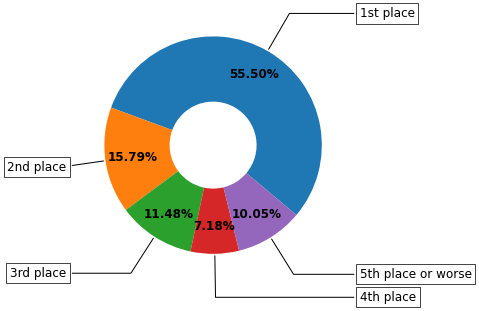

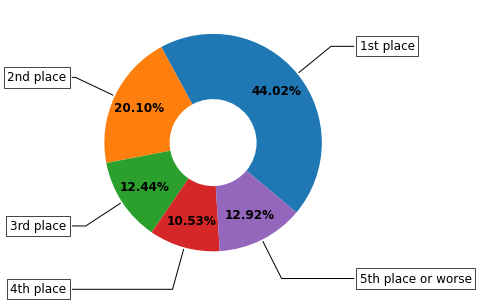

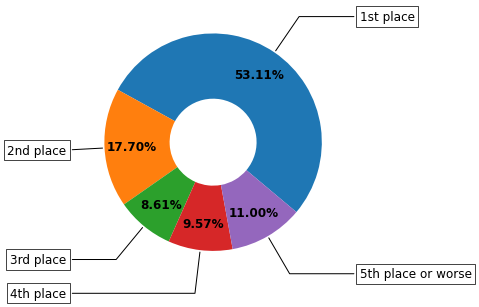

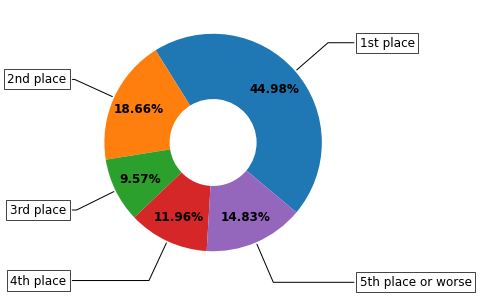

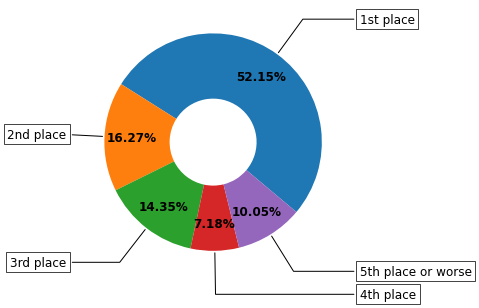

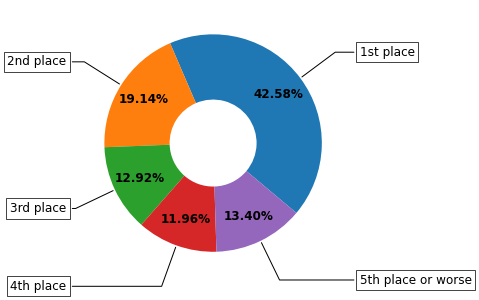

In [21]:
performance_1(label1_test,non_ordered,group_test,False, "without_order.pdf")
performance_1(label2_test,ordered,group_test,True,"with_order.pdf")
performance_1(label1_test,no_human,group_test,False,"no_human1.pdf")

In [22]:
def DCG(annotations,prediction_labels, group, k):
    p = 0
    dcg = 0
    list_dcg = []
    for i in range(len(group)):
        s = prediction_labels[p:(p+group[i])]
        annotation = annotations[p:(p+group[i])]
        #print(annotation)
        #print(s)
        sorted_indices = sorted(range(len(s)), key=lambda k: s[k], reverse = True)
        #print(sorted_indices)
        addition_dcg = 0
        for index in range(k):
            elem = sorted_indices[index]
            relevance = 0
            if annotation[elem] == "None":
                relevance = 0
            elif annotation[elem] == "First place":
                relevance = 3
            elif annotation[elem] == "Second place":
                relevance = 2
            elif annotation[elem] == "Third place":
                relevance = 1
            elif annotation[elem] == "Very bad portmanteau":
                relevance = -2
            else:
                relevance = 0
                
            addition_dcg += relevance/float(math.log10(2 + index))
        dcg += addition_dcg
        list_dcg.append(addition_dcg)

        p = p + group[i]
    return dcg, list_dcg

In [23]:
def performance_2(test_data,labels,group_test,k):
    dcg, dcg_list = DCG(test_data,labels, group_test,k)
    return dcg_list
    

In [24]:
final1 = []
final2 = []
final3 = []
for x in range(1,8):
    k = 0
    j = 0
    i = 0
    compare = []
    list1 = performance_2(annotated_test,non_ordered,group_test,x)
    list2 = performance_2(annotated_test,ordered,group_test,x)
    for index in range(len(list1)):
        if list1[index] > list2[index]:
            k += 1
        elif list1[index] == list2[index]:
            i += 1
        else: 
            j += 1
    final1.append(k)
    final2.append(j)
    final3.append(i)
    

final4 = []
final5 = []
final6 = []    
for x in range(1,8):
    k = 0
    j = 0
    i = 0
    compare = []
    list1 = performance_2(annotated_test,non_ordered,group_test,x)
    list3 = performance_2(annotated_test,no_human, group_test,x)
    for index in range(len(list1)):
        if list1[index] > list3[index]:
            k += 1
        elif list1[index] == list3[index]:
            i += 1
        else: 
            j += 1
    final4.append(k)
    final5.append(j)
    final6.append(i)
    
final7 = []
final8 = []
final9 = []    
for x in range(1,8):
    k = 0
    j = 0
    i = 0
    compare = []
    list2 = performance_2(annotated_test,ordered,group_test,x)
    list3 = performance_2(annotated_test,no_human, group_test,x)
    for index in range(len(list1)):
        if list2[index] > list3[index]:
            k += 1
        elif list2[index] == list3[index]:
            i += 1
        else: 
            j += 1
    final7.append(k)
    final8.append(j)
    final9.append(i)

In [25]:
def plotje(lijst1,lijst2,lijst3, human):
    if human == True:
        plt.figure(facecolor=(1, 1, 1))
        X = ['1','2','3','4','5','6','7']

        ind = np.arange(len(X)) 
        width = 0.25

        bar1 = plt.bar(ind, lijst1, width, color = 'r')

        bar2 = plt.bar(ind+width, lijst2, width, color='g')

        bar3 = plt.bar(ind+width*2, lijst3, width, color = 'b')
        plt.ylabel("Amount of portmanteau groups")
        plt.xlabel('Number of ranked portmanteaus taken into account (= n )')

        plt.xticks(ind+width,['1', '2', '3','4','5','6','7'])
        plt.legend( (bar1, bar2, bar3), ('Binair model using first place labels', 'Model using nuanced weights', 'Tie') )
        plt.show()
    else:
        plt.figure(facecolor=(1, 1, 1))
        X = ['1','2','3','4','5','6','7']

        ind = np.arange(len(X)) 
        width = 0.25

        bar1 = plt.bar(ind, lijst1, width, color = 'r')

        bar2 = plt.bar(ind+width, lijst2, width, color='g')

        bar3 = plt.bar(ind+width*2, lijst3, width, color = 'b')
        plt.ylabel("Amount of portmanteau groups")
        plt.xlabel('Number of ranked portmanteaus taken into account (= n )')

        plt.xticks(ind+width,['1', '2', '3','4','5','6','7'])
        plt.legend( (bar1, bar2, bar3), ('Binair model using first place labels', 'Binair model using correct portmanteaus', 'Tie') )
        plt.show()
        

##### Technique two: using the DCG score to take into account the full obtained ranking

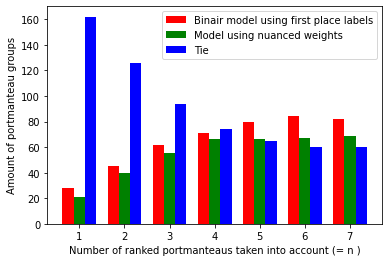

In [26]:
plotje(final1,final2,final3, True)

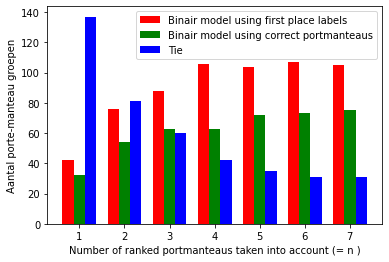

In [27]:
plotje(final4,final5,final6, False)